In [ ]:
# Mount to my google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Path to file in my drive
zip_file_path = '/content/drive/MyDrive/International_Trade_Database.zip'

# Extract from zip file
df = pd.read_csv(zip_file_path, compression='zip')

# Show data
print(df)


       ReporterISO3 ReporterName PartnerISO3 PartnerName  Year TradeFlowName  \
0               AFG  Afghanistan         SWE      Sweden  2017        Export   
1               AFG  Afghanistan         JOR      Jordan  2018        Export   
2               AFG  Afghanistan         JOR      Jordan  2017        Export   
3               AFG  Afghanistan         ITA       Italy  2018        Export   
4               AFG  Afghanistan         ITA       Italy  2017        Export   
...             ...          ...         ...         ...   ...           ...   
634504          ZWE     Zimbabwe         BRA      Brazil  2000        Export   
634505          ZWE     Zimbabwe         BOL     Bolivia  2000        Export   
634506          ZWE     Zimbabwe         BMU     Bermuda  2002        Export   
634507          ZWE     Zimbabwe         BLZ      Belize  2000        Export   
634508          ZWE     Zimbabwe         ZMB      Zambia  2011        Export   

        TradeValue in 1000 USD  
0     

In [ ]:
# Create a new dataframe that is grouped by Reporter, Partner, and Year where tradeValue is for total year.
# Must use reset_index() to make the data into a data frame
yearly_trade = df.groupby(['ReporterISO3', 'PartnerISO3', 'Year'])['TradeValue in 1000 USD'].sum().reset_index()

# Show new dataframe
print(yearly_trade.head(20))

   ReporterISO3 PartnerISO3  Year  TradeValue in 1000 USD
0           ABW         AIA  2001                  49.922
1           ABW         AIA  2002                 773.575
2           ABW         AIA  2003                  63.464
3           ABW         ANT  2000                7577.274
4           ABW         ANT  2001               12061.983
5           ABW         ANT  2002               10503.139
6           ABW         ANT  2003                9678.843
7           ABW         ANT  2004                8892.983
8           ABW         ANT  2005                5111.350
9           ABW         ANT  2006                8913.426
10          ABW         ANT  2007               12896.870
11          ABW         ANT  2008               11416.115
12          ABW         ANT  2009               26511.732
13          ABW         ANT  2010               18972.580
14          ABW         ARE  2000                   0.933
15          ABW         ARE  2003                  79.251
16          AB

In [ ]:
from sklearn.model_selection import train_test_split

# x is data use to predict
x = yearly_trade.drop(columns=['TradeValue in 1000 USD'])
# y data we are trying to predict
y = yearly_trade['TradeValue in 1000 USD']

# Split test and train data (30% test data)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

print("train shape:", x_train.shape)
print("test shape:", x_test.shape)

train shape: (444156, 3)
test shape: (190353, 3)


In [ ]:
import matplotlib.pyplot as plt
# Import Regressor because predicting a number (Trade Value)
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Need to use One Hot Encoder to make usable data for training (ISO3 into numbers)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
# Split feature into categorical and numric features
cat_features = ['ReporterISO3', 'PartnerISO3']

num_features = ['Year']

In [ ]:
# Transform categorical data with One Hot Encoder into numbers
transformer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', 'passthrough', num_features)
],
    remainder='passthrough'
                                )

In [ ]:
# Use transformer to change data for test and train
x_train_transformed = transformer.fit_transform(x_train)
x_test_transformed = transformer.transform(x_test)

In [ ]:
# Regressor model
reg = DecisionTreeRegressor(random_state = 40)

# Fit to training data
reg.fit(x_train_transformed, y_train)

# Make Predictions
y_pred = reg.predict(x_test_transformed)

In [ ]:
# Evaluate Error
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print mean squared error
print("MSE:", mse)
# What percent of variation is explained by the feature of the model
print("R2:", r2)

MSE: 8061830287077.093
R2: 0.9824045399395612


In [ ]:
# Create new data frame to predict from
new = pd.DataFrame({
    'ReporterISO3': ['USA', 'USA', 'USA'],
    'PartnerISO3': ['CHN', 'CHN', 'CHN'],
    'Year': [2015,2025, 2035]
})

print(new)

  ReporterISO3 PartnerISO3  Year
0          USA         CHN  2015
1          USA         CHN  2025
2          USA         CHN  2035


In [ ]:
# Use transformer to transform to usable data
new_transformed = transformer.transform(new)

In [ ]:
import numpy as np

# Make it so it does not print in cientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Predict new values
predict_TradeValue = reg.predict(new_transformed)

# Add to values to data frame
new['Predicted TradeValue in 1000 USD'] = predict_TradeValue

# Print new dataframe
print(new)

  ReporterISO3 PartnerISO3  Year  Predicted TradeValue in 1000 USD
0          USA         CHN  2015                      107767276.06
1          USA         CHN  2025                      132101045.76
2          USA         CHN  2035                      132101045.76


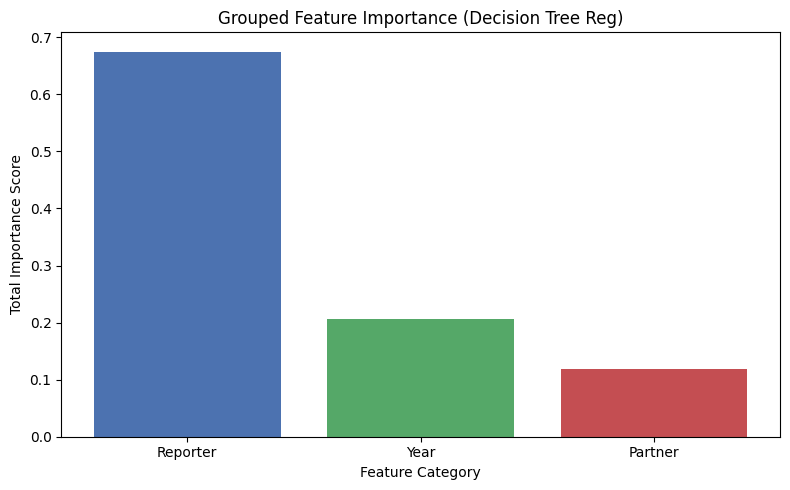

In [ ]:
# Graph the Importance of each feature

# Get the feature names out of transformer
feature_names = transformer.get_feature_names_out()

# Importance of each feature from model
importances = reg.feature_importances_

# Map names to score in pandas series
importance_series = pd.Series(importances, index=feature_names)

# Group importance in Reporter, Partner, and Year
grouped_importances = {
    'Reporter': importance_series[importance_series.index.str.startswith('cat__ReporterISO3')].sum(),
    'Partner': importance_series[importance_series.index.str.startswith('cat__PartnerISO3')].sum(),
    'Year': importance_series[importance_series.index.str.startswith('num__Year')].sum()
}

# Make a dataframe with data
grouped_df = pd.DataFrame(grouped_importances.items(), columns=['Feature', 'Importance'])
grouped_df = grouped_df.sort_values(by='Importance', ascending=False)

# Plot data frame with Importance score for each Feature
plt.figure(figsize=(8, 5))
plt.bar(grouped_df['Feature'], grouped_df['Importance'], color=['#4C72B0', '#55A868', '#C44E52'])

plt.title('Grouped Feature Importance (Decision Tree Reg)')
plt.xlabel('Feature Category')
plt.ylabel('Total Importance Score')
plt.tight_layout()

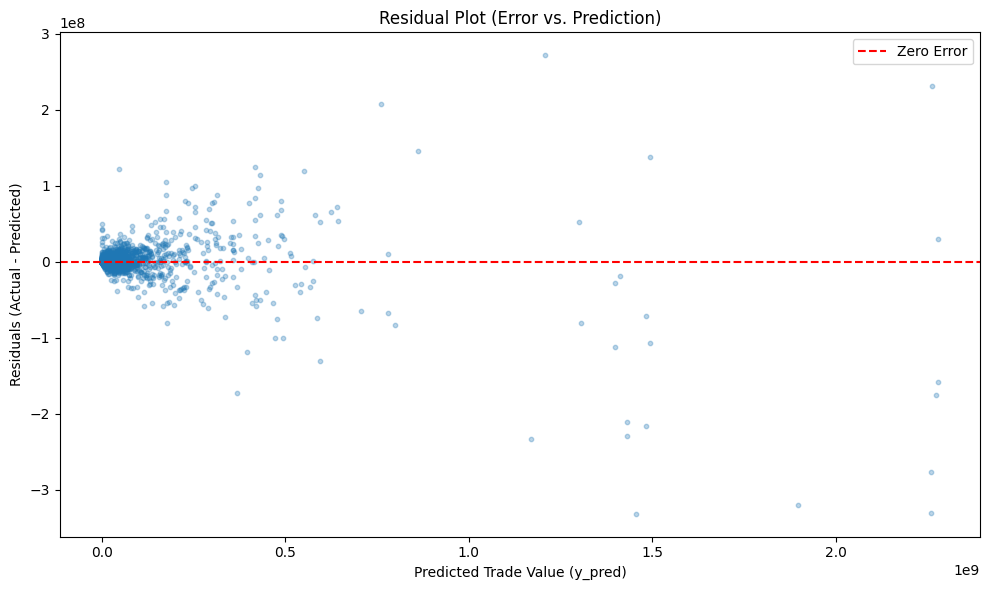

In [ ]:
# Plot diffence between Actual and Predicted
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3, s=10)
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error') # Add horizontal line at 0
plt.xlabel('Predicted Trade Value (y_pred)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot (Error vs. Prediction)')
plt.legend()
plt.tight_layout()